# Introducción.
```{index} QUBO
```

Como ya se ha comentado en capítulos anteriores, los problemas de tipo QUBO, se basan en formular el problema a optimizar mediante expresiones matemáticas de la forma siguiente (<a href="https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization" target="_blank"> ver en wikipedia </a>):

$$E_{qubo}(a_{i},b_{ij};x_{i})=\sum_{i}a_{i}x_{i}+\sum_{i<j}b_{ijj}x_{i}\cdot x_{j}$$

Donde $x_i\in\{0,1\}$.

En este capítulo vamos a aprender a formular problemas de este tipo y adaptarlos a los requerimientos exigidos por los ordenadores de D-Wave, para que se puedan resolver mediante programación cuántica, si bien es de advertir que cuando el problema planteado no tenga una entidad considerable se procederá a resolverlo desde el ordenador personal con la finalidad de no agotar los escasos recursos gratuitos que ofrece D-Wave. Para problemas de mayor entidad, lógicamente se pueden utilizar los solvers que ofrece esa compañía para lanzarlos en ordenadores cuánticos reales.

Antes de seguir adelante, y dado que en este tipo de trabajos suele ser bastante habitual multiplicar polinomios, vamos a refrescar estos conceptos a fin de que el lector se familiarice con ellos (lógicamente el lector que ya tenga esos conocimientos puede saltar este apartado)

(multiplicacion_polinomios)=
## Multiplicación de polinomios.
```{index} Multiplicación  polinomios
```

Para comenzar este apartado, se remite al lector a que <a href="https://www.youtube.com/watch?v=jpD_BugTR6I" target="_blank"> visualice este vídeo </a>.

De todas y a modo de ejemplo a continuación se muestra un desarrollo matemático, en el que se puede ver la metodología existente para realizar esta tarea.

![Multiplicación polinomios](img/polinomios_multiplicacion.PNG)

Como se verá en aparados posteriores, otra de las necesidades que se tiene en este campo de optimiación aplicando metodología QUBO es desarrollar expresiones de la forma  $\left(\left(\sum_{i=0}^{n}x_{i}\right)-c\right)^{2}$, cuyo desarrollo matemático sería el siguiente:

$$\left(\left(\sum_{i=0}^{n}x_{i}\right)-c\right)^{2}=\left(\sum_{i}x_{i}\right)^{2}-2c\sum_{i}x_{i}+c^{2}=$$

$$=\sum_{i}x_{i}^{2}+2\cdot\left(\sum_{i=0}^{n}\sum_{j>i}^{n}x_{i}x_{j}\right)-2c\left(\sum_{i=0}^{n}x_{i}\right)+c^{2}$$

## Problema inicial básico.

Para ir entrando en materia, vamos a comenzar con un problema básico consistente en lo siguiente. Supongamos que queremos asignar un color (y sólo uno) a cada una de las regiones de un mapa.

A este tipo de problemas se le suele designar como "exactamente uno" o también "one-hot", y para su resolución vamos a crear tres variables binarias (iniciales de cada color a utilizar) que las denominaremos: r,g,b (iniciales de red, green y blue en inglés). 

En este caso el problema consiste en cómo escribir una función que se minimice cuando exactamente una de estas variables es igual a 1. En este caso estaremos también cuando por ejemplo se quiera poner una restricción en la forma siguiente:

$$r+g+b=1 $$

En este caso la formulación QUBO que debe implementarse es la siguiente:

$$(1-r-g-b)^{2}=1-r-g-b+2br+2gr+2bg$$

Observar que a la igualdad anterior se llega multiplicando el polinomio consigo mismo y teniendo en cuenta que al trabajar con variables binarias que sólo toman los valores 0 ó 1 entonces se tiene que $x_i^2=1$. 

La formulación de este problema utilizando programación de tipo QUBO sería la siguiente: 

In [6]:
from dimod import BinaryQuadraticModel, to_networkx_graph
bqm = BinaryQuadraticModel('BINARY')

# añadimos los términos lineales
bqm.add_variable("red",-1)
bqm.add_variable("green",-1)
bqm.add_variable("blue",-1)

# Añadimos los términos cuadráticos
bqm.add_interaction("red","green",2)
bqm.add_interaction("red","blue",2)
bqm.add_interaction("blue","green",2)

En la programación QUBO, este tipo de problemas también se puede representar como un objeto de tipo networks, de tal manera que en los vértices se situarían los valores de los términos lineales, y en los arcos (edges) estarían los valores de los términos cuadráticos. A continuación se muestra cómo poder este diagrama en el ejemplo con el que estamos trabajando.

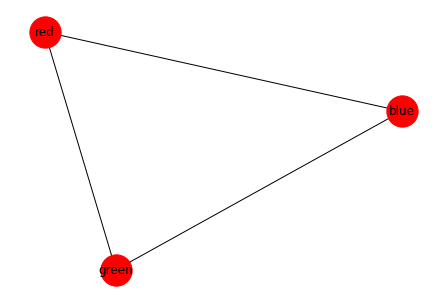

In [16]:
import networkx as nx
nx.draw(to_networkx_graph(bqm), with_labels = True, node_size=980, node_color='red')

A continuación procedemos a utilizar el solver ExatSolver para encontrar los valores que minimizan la expresión anterior y comprobar que realmente las soluciones óptimas (que tienen menor energía), son las que sólo tienen un valor 1 en sólo una de las tres variables con las que trabajamos.

In [18]:
from dimod import ExactSolver

solver = ExactSolver()
response = solver.sample(bqm)
print(response)

  blue green red energy num_oc.
1    0     0   1   -1.0       1
3    0     1   0   -1.0       1
7    1     0   0   -1.0       1
0    0     0   0    0.0       1
2    0     1   1    0.0       1
4    1     1   0    0.0       1
6    1     0   1    0.0       1
5    1     1   1    3.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


Como podemos observar en la salida anterior, las soluciones son las que esperamos.

![Soluciones QUBO](img/soluciones_1.PNG)

Las tres primeras soluciones son las que estábamos buscando y son las que tienen menor energía del sistema y por lo tanto son las que minimizan la ecuación de la función objetivo con la que trabajamos. El restos de soluciones (excited states) se corresponden con estados excitados y por lo tanto no son posiciones en las que se alcanza una menor energía del sistema.

El problema anterior tiene pocas variables y entonces se pueden definir una a una como así se ha hecho anteriormente, pero en los problemas reales nos encontramos con muchas variables y combinaciones dos a dos  de las mimas lo cual dificulta la formulación del problema como se ha hecho anteriormente.

Con el código que sigue, se pretende indicar al lector un posible camino a seguir para formular que contengan muchas más variables

In [19]:
# definimos una lista con los nombres de las variables
variables = ["red","blue","green"]
# Añadimos las variables mediante un bucle for
for variable in variables:
    bqm.add_variable(variable,-1)

In [21]:
# Utilizamos la librería itertools para hacer todas las combinaciones
import itertools
combinaciones = list(itertools.combinations(variables, 2))
combinaciones

[('red', 'blue'), ('red', 'green'), ('blue', 'green')]

In [23]:
for combinacion in combinaciones:
        bqm.add_interaction(combinacion[0],combinacion[1],2)

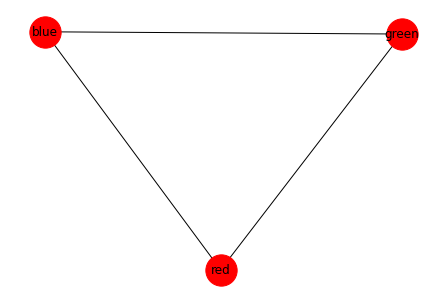

In [24]:
nx.draw(to_networkx_graph(bqm), with_labels = True, node_size=980, node_color='red')

In [25]:
response = solver.sample(bqm)
print(response)

  blue green red energy num_oc.
1    0     0   1   -2.0       1
3    0     1   0   -2.0       1
7    1     0   0   -2.0       1
0    0     0   0    0.0       1
2    0     1   1    0.0       1
4    1     1   0    0.0       1
6    1     0   1    0.0       1
5    1     1   1    6.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


## Formulación problemas QUBO (o Ising).
```{index} Parámetro de lagrange, funciones de penalización, penalty functions
```

En este tipo de problemas, normalmente se formulan vía una función objetivo, que siempre es para minimizar (por lo tanto si lo que se quiere es maximizar, lo que se hace es cambiar el signo de la función objetivo) y una serie de restricciones o condiciones que deben verificar las variables de problema planteado. Por lo tanto la fórmula genérica en este tipo de problemas es la siguiente:
<center><br>
Ising ó QUBO = min(objetivo+$\gamma \cdot$(restricciones))
    </center><br>
El valor de $gamma$ es el denominado *parámetro de lagrange*.

Por lo tanto lo que se debe fijar es la función objetivo y las restricciones que deben cumplirse. Normalmente estas restricciones se ponen de acuerdo al concepto de funciones de penalización, o penalty functions que [veremos en el siguiente capítulo](penalty-functions).

Veamos un ejemplo sobre la implementación de un problema BQM. Supongamos que tenemos el siguiente conjunto de números: {17,21,19}, se trata de elegir dos números de manera que la suma sea la mínima posible.

Para resolver este problema, lo primero que haremos será definir las variables $x_i$ que tendrá un valor 1 si el número i-ésimo es seleccionado y cero en caso contrario. Por lo tanto la función a minimizar sería la siguiente (función objetivo):

$$min(17x_{1}+21x_{2}+19x_{3})$$

La restricción sería que elijamos sólo dos números, lo cual escrito en formulación matemática implica lo siguiente:

$$ x_1+x_2+x_3=2 $$

Para incluir esta restricción en un problema QUBO, debemos calcular lo siguiente: $(x_1+x_2+x_3-2)^2$, que realmente es una función de penalización, de manera que va a valer cero para los números que cumplen esta restricción y un valor suficientemente alto para los que no lo cumplen (que viene representado por el parámetro de Lagrange $\gamma$). En consecuencia el problema QUBO quedaría expresado de la siguiente manera:

$$ min \,(17x_{1}+21x_{2}+19x_{3})+\gamma(x_1+x_2+x_3-2)^2$$  

Ahora lo que procede es desarrollar la expresión $(x_1+x_2+x_3-2)^2$, para ello simplemente utilizamos la expresión obtenida [un apartado anterior](multiplicacion_polinomios), o bien multiplicamos dos veces el polinomio y al final se obtiene la  siguiente expresión: 

$$x_1+x_2+x_3+2x_1x_2+2x_2x_3+2x_2x_3-4x_1-4x_2-4x_3+4 =$$

$$ =-3x_1-3x_2-3x_3+2x_1x_2+2x_1x_3+2x_2x_3$$

En consecuencia la función que nos queda es la siguiente:

$$ min \,(17x_{1}+21x_{2}+19x_{3})+\gamma(-3x_1-3x_2-3x_3+2x_1x_2+2x_1x_3+2x_2x_3)$$ 

Tomemos por ejemplo $\gamma=5$ y entonces nos quedaría los siguiente:

$$ min \, (2x_1+6x_2+4x_3+10x_1x_2+10x_1x_2+10x_2x_3)$$

Por lo tanto resolvemos este último problema de la siguiente forma

In [34]:
from dimod import BinaryQuadraticModel, to_networkx_graph
bqm = BinaryQuadraticModel('BINARY')

# añadimos los términos lineales
bqm.add_variable("x_1",2)
bqm.add_variable("x_2",6)
bqm.add_variable("x_3",4)

# Añadimos los términos cuadráticos
bqm.add_interaction("x_1","x_2",10)
bqm.add_interaction("x_1","x_3",10)
bqm.add_interaction("x_2","x_3",10)

In [35]:
bqm

BinaryQuadraticModel({'x_1': 2.0, 'x_2': 6.0, 'x_3': 4.0}, {('x_2', 'x_1'): 10.0, ('x_3', 'x_1'): 10.0, ('x_3', 'x_2'): 10.0}, 0.0, 'BINARY')

In [43]:
from dimod import ExactSolver

solver = ExactSolver()
response = solver.sample(bqm)

print(response)

  x_1 x_2 x_3 energy num_oc.
0   0   0   0    0.0       1
1   1   0   0    2.0       1
7   0   0   1    4.0       1
3   0   1   0    6.0       1
6   1   0   1   16.0       1
2   1   1   0   18.0       1
4   0   1   1   20.0       1
5   1   1   1   42.0       1
['BINARY', 8 rows, 8 samples, 3 variables]


Como podemos observar, las soluciones que se devuelven con este solver son todas las posibles ordenadas de menor a mayor energía. Por lo tanto, debemos seleccionar las factibles y de entre ellas la que tenga menor energía. Veamos algunas propiedades del objeto response.

In [49]:
type(response)

dimod.sampleset.SampleSet

In [50]:
for sample in response.samples():   
    print(sample)

{'x_1': 0, 'x_2': 0, 'x_3': 0}
{'x_1': 1, 'x_2': 0, 'x_3': 0}
{'x_1': 0, 'x_2': 0, 'x_3': 1}
{'x_1': 0, 'x_2': 1, 'x_3': 0}
{'x_1': 1, 'x_2': 0, 'x_3': 1}
{'x_1': 1, 'x_2': 1, 'x_3': 0}
{'x_1': 0, 'x_2': 1, 'x_3': 1}
{'x_1': 1, 'x_2': 1, 'x_3': 1}


In [65]:
response.samples()[1]

{'x_1': 1, 'x_2': 0, 'x_3': 0}

In [66]:
for h  in range(len(response.samples())):
    print(sum(response.samples()[h].values()))

0
1
1
1
2
2
2
3


Vamos a seleccionar a continuación las soluciones factibles y entre ellas la primera que se obtenga.

In [67]:
for h  in range(len(response.samples())):
    a =sum(response.samples()[h].values())
    if a == 2:
        print(response.samples()[h])

{'x_1': 1, 'x_2': 0, 'x_3': 1}
{'x_1': 1, 'x_2': 1, 'x_3': 0}
{'x_1': 0, 'x_2': 1, 'x_3': 1}


Por lo tanto la solución buscada sería elegir el primero y último número.

Notar que este problema sería mucho más fácil resolverlo si lo construimos y resolvemos con modelo CQM (sontrained quadratic model) que se verá en un [capítulo posterior](cqm).

## Problema partición grafo.

En este apartado vamos a resolver otro problema mediante la programación QUBO. Este problema va a consistir en los siguiente: Dado un grafo G, debemos dividir este grafo en dos conjuntos de tal manera que los dos grupos tengan el mismo numero de vértices, y que los arcos (edges) entre los dos conjuntos sean lo menos posibles.

![ejemplo partición](img/grafo1.PNG)

En este ejemplo la *función objetivo* será construida bajo la idea de que el número de arcos entre los dos conjuntos sea el menor posible, y la restricción será que el número de vértices en cada uno de los dos conjuntos sea el mismo.

Para resolver este problema llamemos a un conjunto de vértices A y el otro B, y definamos las siguientes variables binarias.

$$x_{i}=\begin{cases}
1 & si\ nodo\ i\ est\acute{a}\ en\ A\\
0 & en\ caso\ contrario
\end{cases}$$

Para construir la función objetivo, vamos a construir una función de penalización en base a la tabla de la verdad que se muestra a continuación.

| x1 | x2 | coste arco (x1,x2) |
|----|----|--------------------|
| 0  | 0  | 0                  |
| 0  | 1  | 1                  |
| 1  | 0  | 1                  |
| 1  | 1  | 0                  |

Expliquemos cómo hemos construido esta tabla de la verdad, pues es un procedimiento que se suele utilizar en la programación QUBO para construir funciones de penalización.

Las dos primeras columna de la tabla muestran los diferentes conjuntos de pares de valor que se pueden formar con x1 y x2, y la tercera columna muestra el valor 0 (menor energia), cuando los dos valores indican pertenencia al mismo conjunto y el valor 1 (mayor energía) cuando son de conjuntos diferentes, puesto que es esto último lo que queremos penalizar.

Ahora lo que queremos es encontrar una función matemática que exprese esa situación, y además esta forma matemática deber ser una forma cuadrática, por ser este tipo de expresiones las que acepta QUBO. Por lo tanto la forma matemática deberá tener la siguiente expresión:

$$ ax_1+bx_2+cx_1x_2+d $$

Haremos que esta forma matemática cumpla las condiciones de la tabla de la verdad anterior, por lo tanto para el par de valores (0,0) debe valer 0 y en consecuencia d=0.

Para el par de valores (0,1) se tiene lo siguiente:

$$a\cdot 0+b=1$$

Por lo tanto b=-1. Actuando de la misma manera para el par de valores (1,0) se obtiene que a=-1. Finalmente para el (1,1), se tiene: $1+1+c=0$ y por lo tanto c=-2. En consecuencia, para par de nodos de la red x1 y x2 se debe tener como función de penalización la siguiente:

$$ x_i+x_j-2x_ix_j$$

En resumen, la función objetivo que buscamos es la siguiente:

$$ \sum_{(i,j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})$$

Evaluemos ahora cómo deben ser las restricciones, teniendo en cuenta que los dos conjuntos deben tener el mismo tamaño. Llamamos N al número total de nodos de la red, y entonces el número de nodos en el conjunto A sería: $\sum_{i=1}^{N}x_i=N/2$

Hagamos que la restricción anterior tenga un formato tal que QUBO lo pueda interpretar y para ello lo que debemos de dar los siguientes pasos.

debemos pasar todos los elementos de la igualdad anterior a un miembro y elevar al cuadrado, es decir debemos de calcular:

$$\left(\frac{N}{2}-\sum_{i=1}^{N}x_{i}\right)^{2}$$

Calculamos el cuadrado de esa diferencia y se obtiene

$$\frac{N}{4}-N\sum_{i=1}^{N}x_{i}+\left(\sum_{i=1}^{N}x_{i}\right)^{2}$$

Ahora eliminamos la constante y se tiene:

$-N\sum_{i=1}^{N}x_{i}+\left(\sum_{i=1}^{N}x_{i}\right)^{2}$

En consecuencia, la expresión QUBO que debemos tener en cuenta para minimizar es la siguiente:

$$min\ \sum_{(i,j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})+\gamma\cdot\left(-N\sum_{i=1}^{N}x_{i}+\left(\sum_{i=1}^{N}x_{i}\right)^{2}\right)$$

La última expresión es una suma elevada al cuadrado que QUBO no entiende, por lo que la debemos cambiar ese formato. A continuación, hacemos eso:

$$\left(\sum_{i=1}^{N}x_{i}\right)^{2}=\sum_{i=1}^{N}x_{i}^{2}+\sum_{i=1}^{N}\sum_{j>i}2x_{i}x_{j}=\sum_{i=1}^{N}x_{i}+\sum_{i=1}^{N}\sum_{j>i}2x_{i}x_{j}$$

Por lo tanto la expresión nos queda de la siguiente manera:


$$min\ \sum_{(i,j)\in E}(x_{i}+x_{j}-2x_{i}x_{j})+\gamma\left(-N\sum_{i=1}^{N}x_{i}+\sum_{i=1}^{N}x_{i}+\sum_{i=1}^{N}\sum_{j>i}^{N}2x_{i}x_{j}\right)$$

Simplificando la expresión anterior se tiene como expresión a tener en cuenta para el problema QUBO la siguiente:

$$min\ (2\gamma-2)\sum_{(i,j)\in E}x_{i}x_{j}+\sum_{(i,j)\in E}(x_{i}+x_{j})+\gamma\left(-N\sum_{i=1}^{N}x_{i}+\sum_{i=1}^{N}x_{i}\right)$$

Podemos simplificar aún más la expresión anterior, hasta dejarla como

$$min\ (2\gamma-2)\sum_{(i,j)\in E}x_{i}x_{j}+\sum_{(i,j)\in E}(x_{i}+x_{j})+\gamma\left(1-N\right)\left(\sum_{i=1}^{N}x_{i}\right)$$

